# Linkin Nodes

In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from data.ArticlesParser import process_articles_directory
from data.Graph import *
from data.Preprocessing import *
from utils.Visualization import *
from sentence_transformers import SentenceTransformer, util

c:\Users\angel\anaconda3\envs\ada\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## 1. Preprocessing

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

# change_name_files_plaintext_articles(data_path)

parsed_articles = process_articles_directory(articles_path)
df = pd.DataFrame(parsed_articles, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Áedán_mac_Gabráin,[British History 1500 and before (including Ro...,"Áedán mac Gabráin was king of Dál Riata, a kin..."
1,Åland,"[Countries, European Countries]","Åland (pronounced IPA: ['oːland] in Swedish), ..."
2,Édouard_Manet,[Artists],"Édouard Manet ( January 23, 1832 – April 30, 1..."
3,Éire,"[Countries, European Countries]",Éire ( pronounced [ˈeːrʲə]) is the Irish name ...
4,Óengus_I_of_the_Picts,[British History 1500 and before (including Ro...,"Óengus, son of Fergus ( Hypothetical Pictish f..."


In [7]:
df_links = preprocessing_links(data_path)
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


## 2. Model choice and embeddings

In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [4]:
# This needs to calculate the embeddings for each article and description, takes time.
embedded_articles = articles_to_embeddings(parsed_articles, model)

In [5]:
for title in embedded_articles:
    score = util.dot_score(*embedded_articles[title])
    if score < 0.2:
        print(f"{title} score: {float(score):.4f}")

Amur score: 0.1967
Cheers score: 0.1901
Lottie_Dod score: 0.1621


In [6]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john_embedding, john_desc_embedding = embedded_articles["John_W._Campbell"]
isaac_embedding, isaac_desc_embedding = embedded_articles["Isaac_Asimov"]
print(f"Cosine similarity between article names: {float(util.dot_score(john_embedding, isaac_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(john_desc_embedding, isaac_desc_embedding)):.4f}")

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick_embedding, limerick_desc_embedding = embedded_articles["Limerick"]
poetry_embedding, poetry_desc_embedding = embedded_articles["Poetry"]
print(f"Cosine similarity between article names: {float(util.dot_score(limerick_embedding, poetry_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(limerick_desc_embedding, poetry_desc_embedding)):.4f}")

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter_embedding, winter_desc_embedding = embedded_articles["Winter"]
summer_embedding, summer_desc_embedding = embedded_articles["Summer"]
print(f"Cosine similarity between article names: {float(util.dot_score(winter_embedding, summer_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(winter_desc_embedding, summer_desc_embedding)):.4f}")

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2334
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


Discussion:
Intuitively, articles should be linked if the cosine similarity between descriptions is higher than a certain threshold, while being close to the article names cosine similarity. But it is easier to let a neural network determine the weights while passing on both the article names and descriptions embeddings as variables for each node.

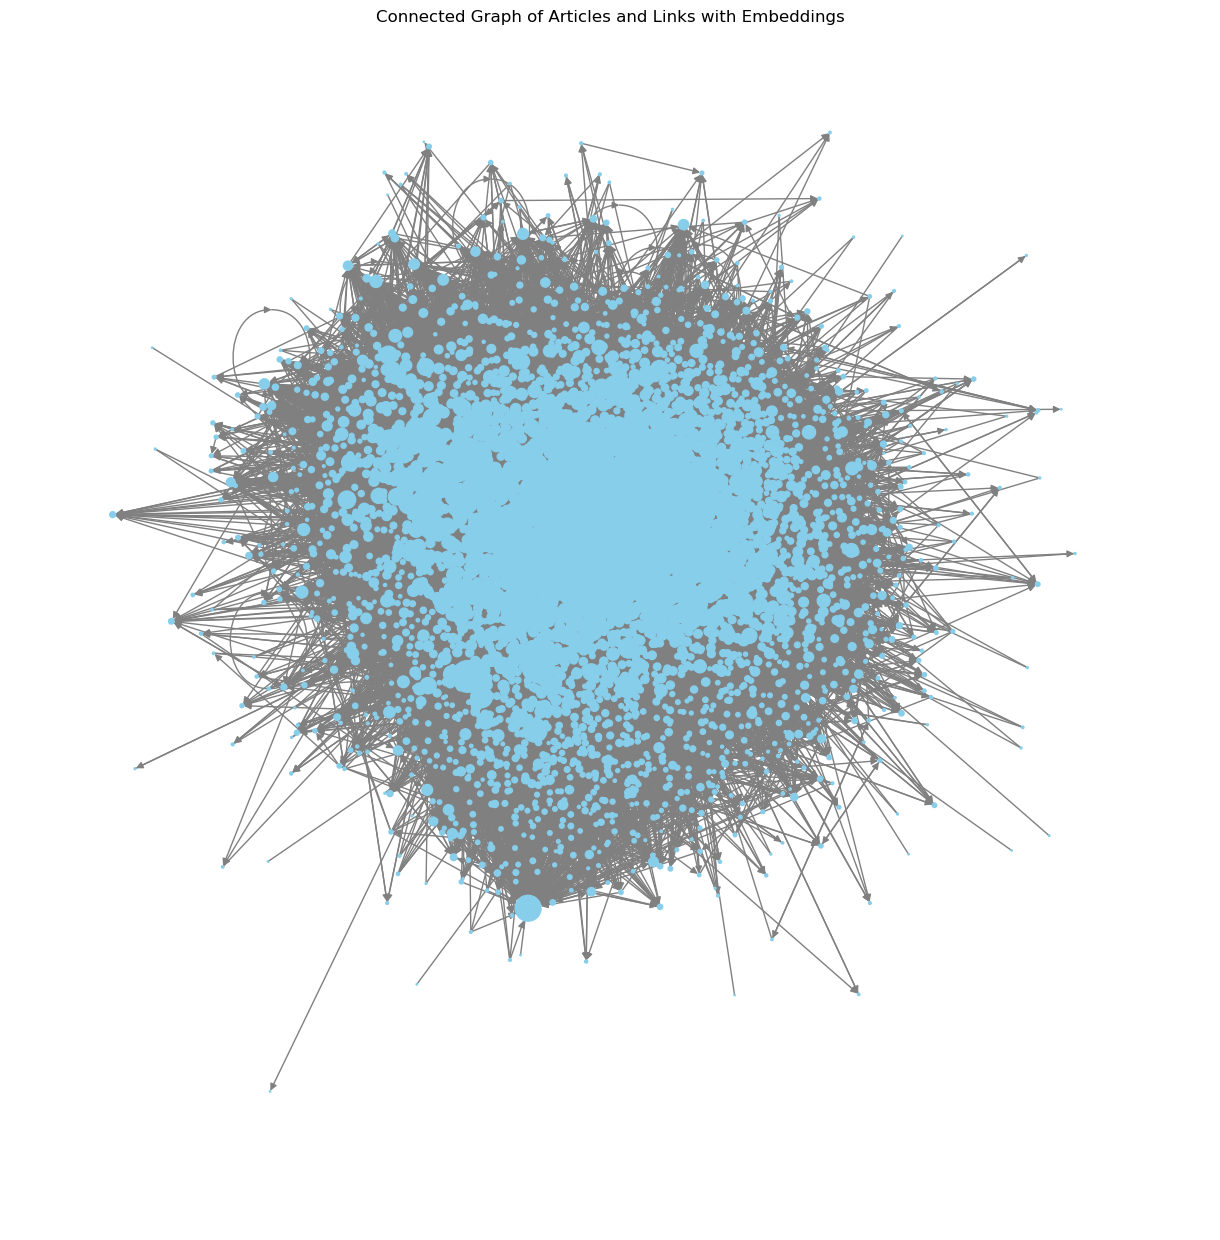

In [8]:
G=create_graph(embedded_articles, df_links)
visualize_graph(G)

### GRAPH STATISTICAL ANALYSIS

To gain a better understanding of the data, some basics but important characteristics of the graph are computed/displayed. This will help guide us in selecting the most appropriate approach for the next steps.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx

#Make sure to have a connected graph without isolated nodes

#Here we create subgraphs for each connected component
components = list(nx.connected_components(G.to_undirected()))
print(f"Number of connected components: {len(components)}")
subgraphs = [G.to_undirected().subgraph(component).copy() for component in components]

for i in range(len(subgraphs)):
    subgraph_1 = subgraphs[i]
    print(f"Number of nodes in subgraph {i}: {subgraph_1.number_of_nodes()}, {subgraph_1.nodes()}")
    print(f"Number of edges in subgraph {i}: {subgraph_1.number_of_edges()}")


Number of connected components: 10
Number of nodes in subgraph 0: 4589, ['Second_Crusade', 'Navassa_Island', 'Evan_Rachel_Wood', 'Tropical_Storm_Henri_(2003)', 'Final_Fantasy_Adventure', 'Tornado', 'John_W._Campbell', 'Whooping_Crane', 'Shigin', 'Hafnium', 'Hawaiian_Goose', 'Ankylosaurus', 'Andriyivskyy_Descent', 'Supermarine_Spitfire', 'Carl_Jung', 'Fine_art', 'Arithmetic', 'Taj_Mahal', 'Social_capital', 'Nepal', 'Book_of_Common_Prayer', 'African_Buffalo', 'Luminiferous_aether', 'Chicago', 'Giza_pyramid_complex', 'Lyme_disease', 'Humour', 'Imperative_programming', 'Brain', 'Coconut', 'Tern', 'Wars_of_the_Roses', 'Davis_Cup', 'Great_Tit', 'Wave–particle_duality', 'Jean_Charles_de_Menezes', 'Local_community', 'Music_of_Spain', 'Terik', 'Bernard_Hinault', "Hickman's_potentilla", 'Eris_(dwarf_planet)', 'Intelligence', 'Margaret_Sanger', 'Bretton_Woods_system', 'Glastonbury_Festival', 'Oxygen', 'Gerald_Ford', 'Antarctic_Treaty_System', 'John_Locke', 'Martin_Luther_King,_Jr.', "Six-party_ta

Except subgraphs[0], the rest correpond to isolated node, so we can get rid of them in the rest of the analysis

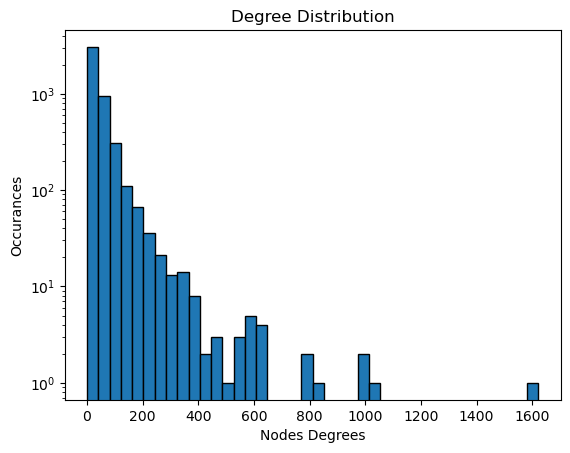

Number of nodes: 4589
Number of edges: 106644
Average degree: 46.48
Network density: 0.0101
Clustering coefficient: 0.2745
Average Shortest path: 2.5253


In [17]:
#subgraphs[0] is fully connected
analyze_graph_statistics(subgraphs[0])

### Results analysis

The graph is medium size and seems well connected, as the number of edges (>100000) is important compared to the number of nodes (~4500), and the average degree is pretty high (46.48).
The distribution of the nodes degrees is a right skewed distribution.
Thought the density is pretty low and indicates potential for discovering new links.
The clustering coefficient indicates that we are more likely to find local clusters.
Finally, it seems that most nodes can be reached from every other node in a small number of steps, as the avergae shortest path is ~2.53.

Thus, the features engineering focus should be on local structure features and short path, but the high connectivity suggests that global features could be important aswell.

## 4. Cosine similarity

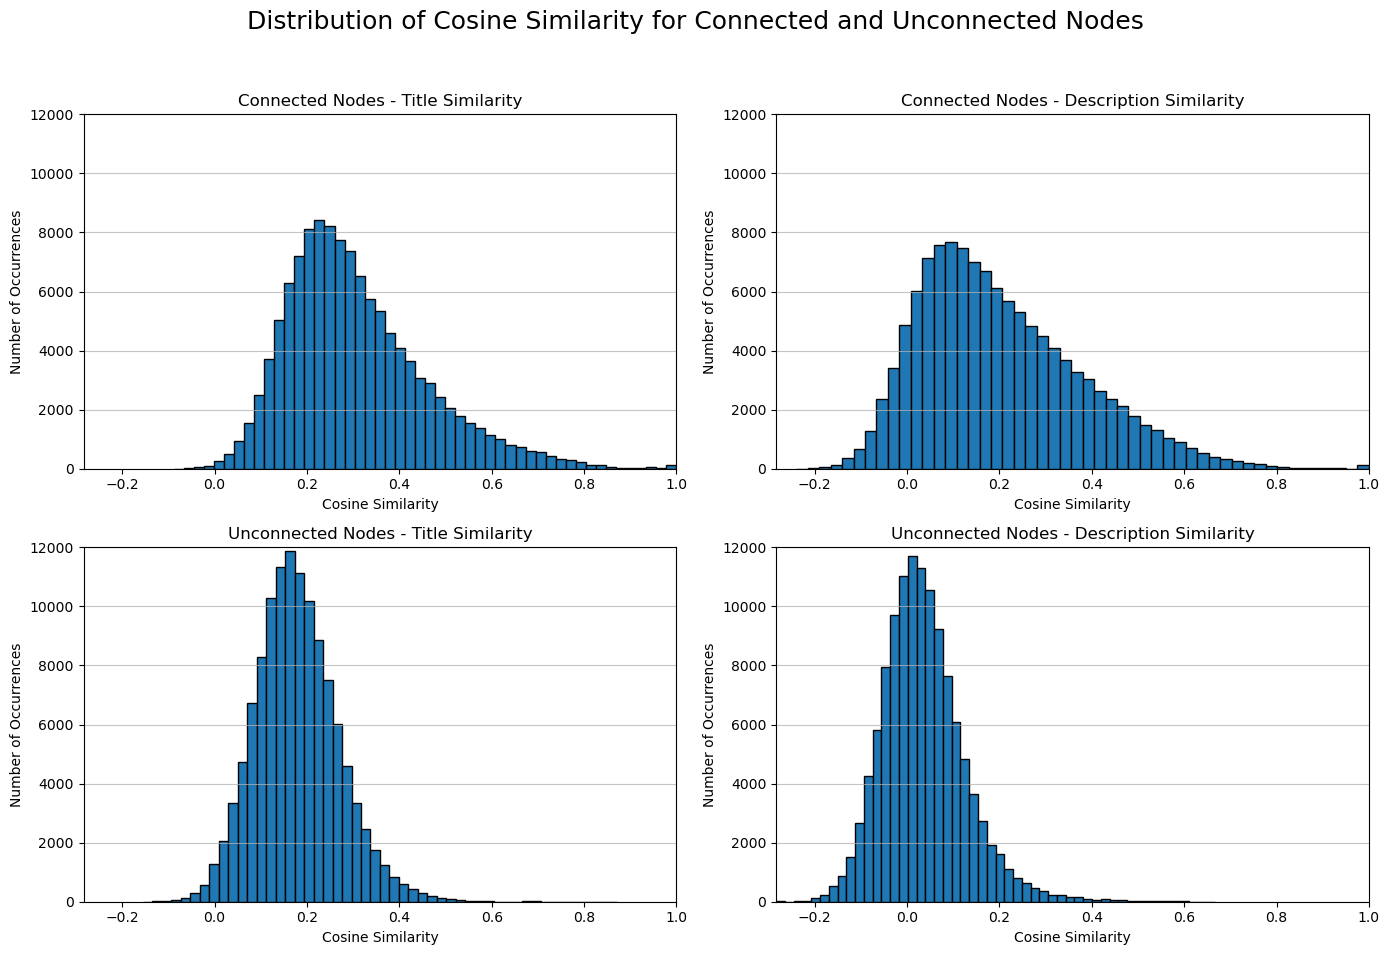

In [9]:
similarities = visualize_node_similarity_distributions(G)

Description:

Now to compare these distribution with the cosine similarities of article titles and descriptions between unconnected nodes, we will take a representative sample of the articles and calculate their cosine similarities.

In [10]:
for s in similarities['unconnected_pairs']:
    if s['title_similarity'] > 0.7 and s['description_similarity'] > 0.6:
        print(s['source'] + ' ' + s['target'])

Flemish_people East_Flemish
East_Flemish Flemish_people
Blue_Whale Whale_shark
Henry_III_of_England Henry_VIII_of_England
Henry_VIII_of_England Henry_III_of_England
Whale_shark Blue_Whale


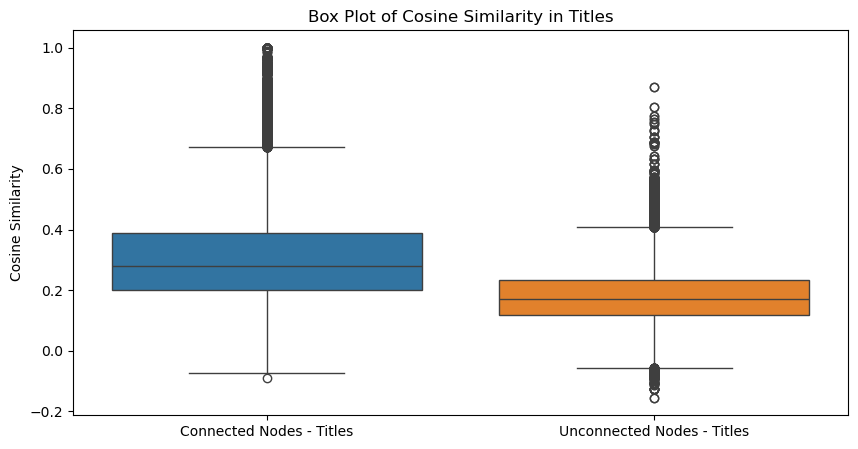

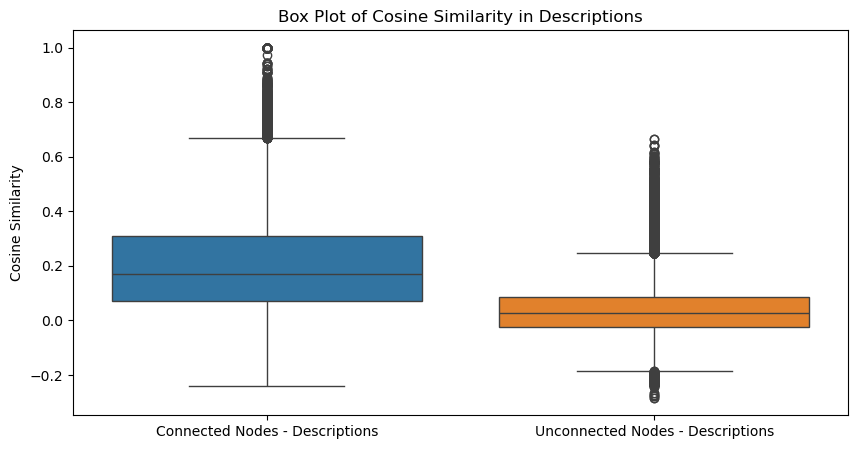

In [11]:
visualize_connected_vs_unconnected_cs_distribution(G, similarities)

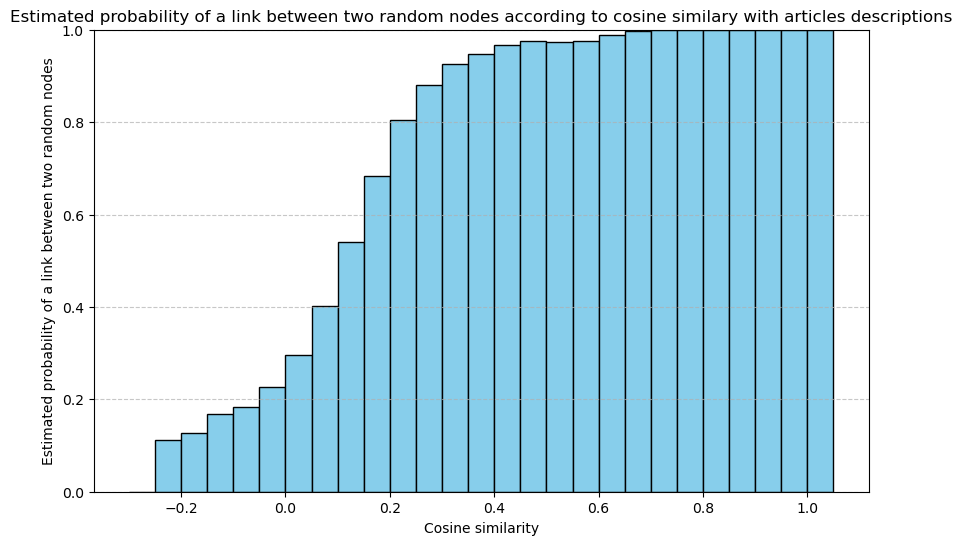

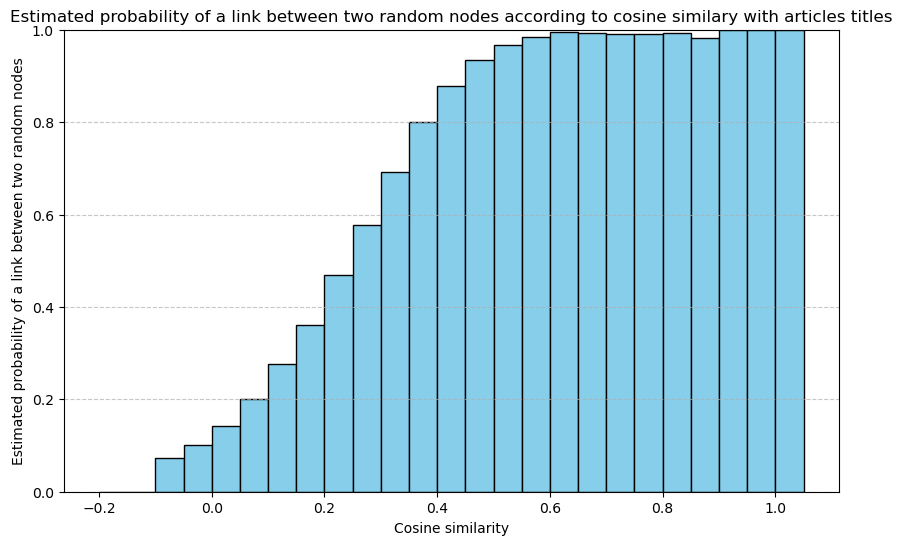

In [13]:
calculate_links_conditional_proba(G,similarities)

## 5. Feature engineering

To train the model, we introduce a set of handcrafted features tailored to the context of link prediction. These features are selected based on the project's aim and the statistical analyses conducted above. They are intended to be the most relevant for achieving effective link creation.

In this section, we start by exploring 4 methods based on node neighborhoods to quantify how likely two nodes are to form a link. These methods are discussed in the paper "The Link Prediction Problem for Social Networks", by Nowell et al.


We begin by computing and visualizing the preferential attachment scores for pairs of nodes, distinguishing between those that are connected and a subset of those that are unconnected. Preferential attachment is the principle that a node with more connections is more likely to acquire additional links. This approach assumes that the likelihood of a new connection involving a node x is directly proportional to the number of its existing neighbors. Additionally, the likelihood of two nodes, x and y, forming a co-authorship connection is related to the product of their respective collaborator counts.

Discussion: The preferential attachment scores for the connected pairs can have very large values because we have a very connected and sparse graph. However, some nodes havec a very high degree, resulting in large values (x_value range). In contrast, the preferential attachment scores for unconnected pairs are significantly smaller. This is due to the fact that these unconnected nodes, lacking a direct link, generally have less common neighbors, reducing the likelihood of a connection (under the preferential attachment mechanism). 
This difference highlights the impact of common neighbors on connection probability and underscores the structural differences between connected and unconnected pairs in the network.

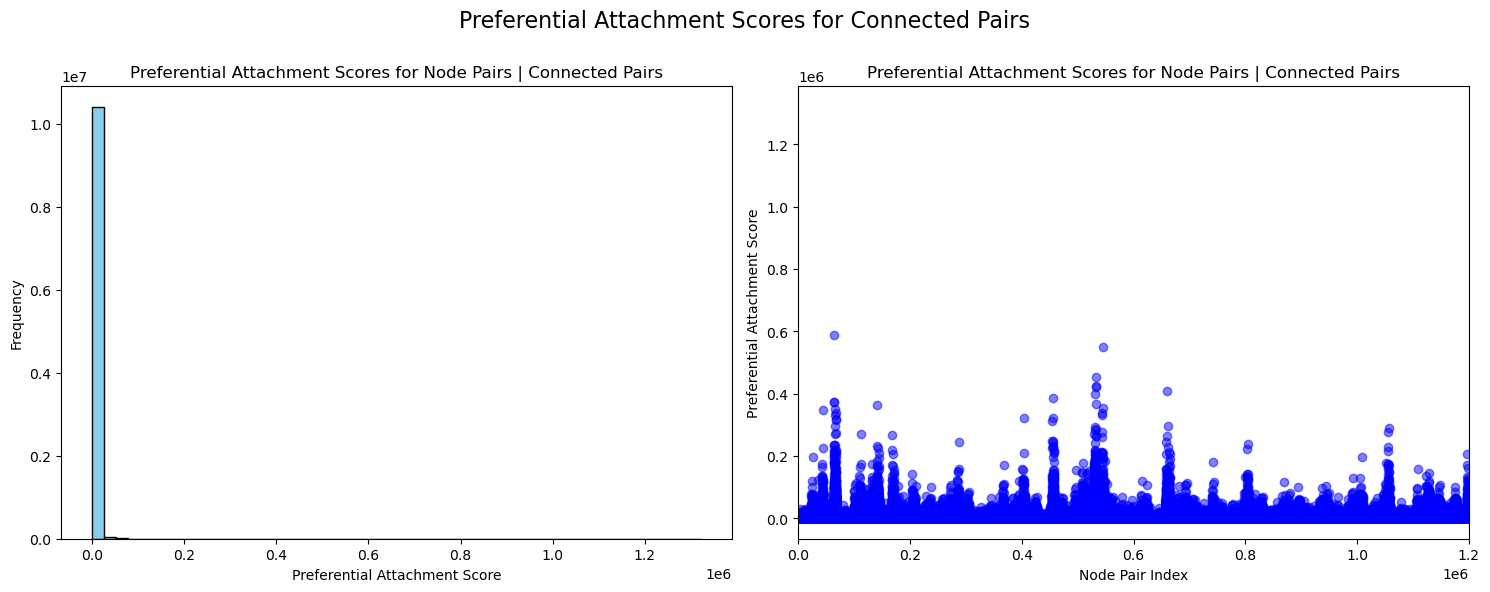

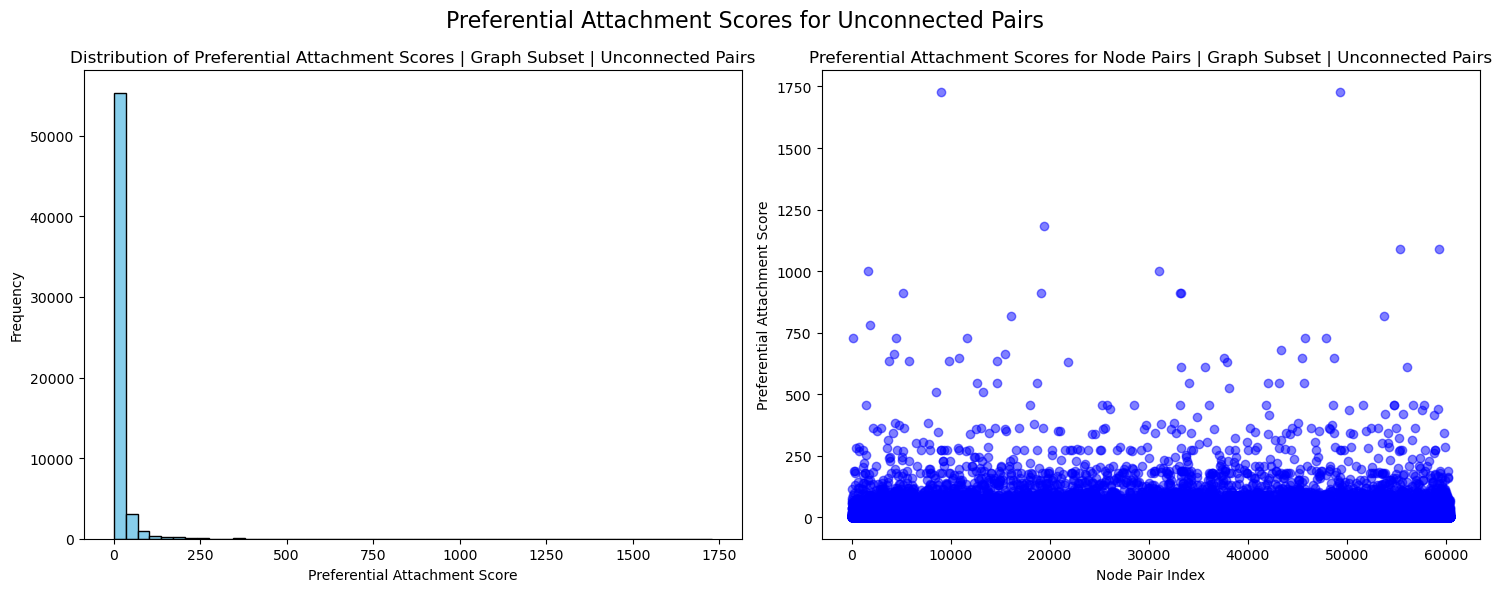

In [34]:
calculate_preferential_attachment(G)

In the plots below and above, we illustrate the preferential attachment scores for connected and unconnected node pairs of our network. The unconnected nodes plots are replotted below to show the graph, since their values are minuscule compared to the connected pairs. 


In [ ]:
calculate_preferential_attachment2(G)

Now, we compare the number of common neighbors between two nodes x and y. Two nodes with a higher number of common neighbors have a higher probability to be linked in the future. 

Discussion: As expected, connected nodes have a higher number of common neighbors, whereas unconnected nodes have a smaller number of common neighbors. 

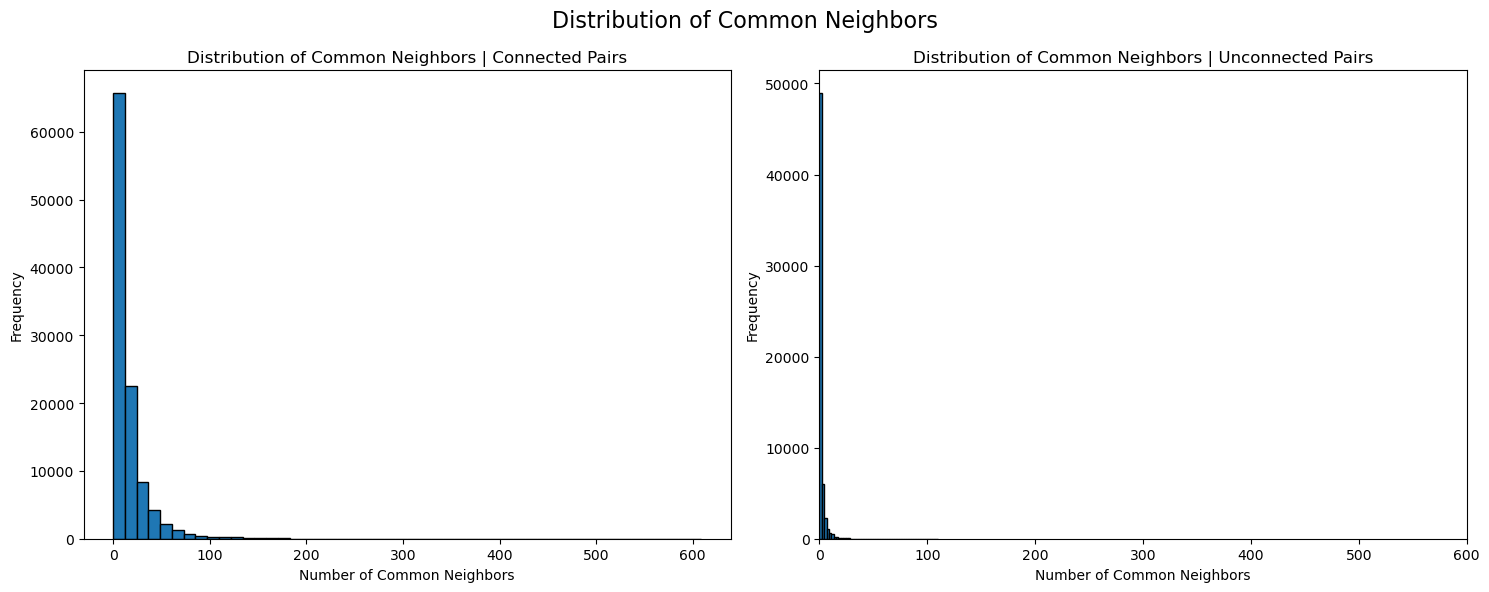

In [32]:
calculate_common_neighbors(G)

In [23]:
#Nodes features 

#Calculate Eigen centrality for all node pairs
#There are others ways to compute the centrality btw
centrality = nx.eigenvector_centrality(subgraphs[0])
data = []
for u, v in centrality.items():
    data.append({"Article_1": u, "eigenvector": v})
    
#Get the values in a dataframe
df_eigen = pd.DataFrame(data)
df_eigen.sort_values("eigenvector", ascending=False, inplace=True)

#Links features

#Calculate Jaccard similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
jaccard_similarities = nx.jaccard_coefficient(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in jaccard_similarities:
    data.append({"Article_1": u, "Article_2": v, "jaccard_similarity": p})

df_jaccard = pd.DataFrame(data)
df_jaccard.sort_values("jaccard_similarity", ascending=False, inplace=True)

# Calculate Adamic_adar_index similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
adamic_adar_index = nx.adamic_adar_index(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in adamic_adar_index:
    data.append({"Article_1": u, "Article_2": v, "adamic_adar_index": p})

df_adamic = pd.DataFrame(data)
df_adamic.sort_values("adamic_adar_index", ascending=False, inplace=True)


In [17]:
df_eigen

,Article_1,eigenvector
3417,United_States,0.179635
4399,France,0.142220
720,United_Kingdom,0.137784
447,Europe,0.132176
3804,Germany,0.120921
...,...,...
2190,Ohm,0.000016
2038,Scheme_programming_language,0.000015
2323,Duchenne_muscular_dystrophy,0.000014
3754,Klinefelter's_syndrome,0.000014


In [18]:
df_jaccard

,Article_1,Article_2,jaccard_similarity
2392122,Hawfinch,Eurasian_Bullfinch,1.0
2614782,Duchenne_muscular_dystrophy,Klinefelter's_syndrome,1.0
4167498,Australian_Green_Tree_Frog,White's_Tree_Frog,1.0
10108960,Eurasian_Bullfinch,Reed_Bunting,1.0
2392461,Hawfinch,Reed_Bunting,1.0
...,...,...,...
916433,Lilongwe,Immanuel_Kant,0.0
916435,Lilongwe,Geology_of_the_Grand_Canyon_area,0.0
916436,Lilongwe,Joseph_and_the_Amazing_Technicolor_Dreamcoat,0.0
916437,Lilongwe,Tone_cluster,0.0


In [19]:
df_adamic

,Article_1,Article_2,adamic_adar_index
9427295,United_States,England,83.407958
8674072,Binomial_nomenclature,Chordate,72.607095
9426992,United_States,London,68.688406
456522,Scientific_classification,Europe,59.432855
9807660,China,India,54.999616
...,...,...,...
5823199,Forrest_Gump,Wellington,0.000000
5823198,Forrest_Gump,Music_of_Trinidad_and_Tobago,0.000000
1774378,Scott_Special,Karl_Marx,0.000000
5823196,Forrest_Gump,Aye-aye,0.000000


We can also explore the difference of Jaccard's and Adamic/Adar Coefficients between connected and unconnected pairs.

The Jaccard's coefficient is a commonly used similarity metric in information retrieval. It measures the probability that both x and y have a feature f, knowing that x or y has the feature f (which is randomly selected). In our case, the features are the neighbors. 

Discussion: Below we compare the Jaccard's coefficients for both connected and unconnected node pairs. As expected, the Jaccard coefficient values are higher for connected node pairs, as the likelihood of sharing a neighbor increases when nodes are directly connected.

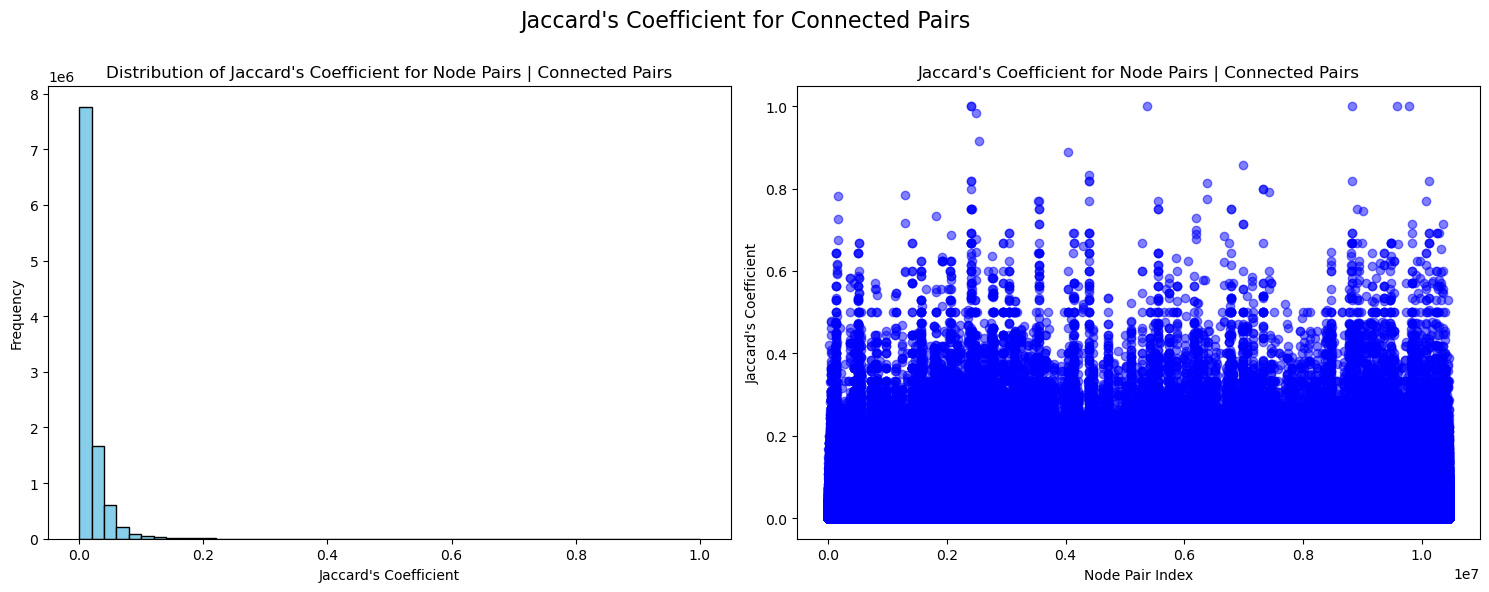

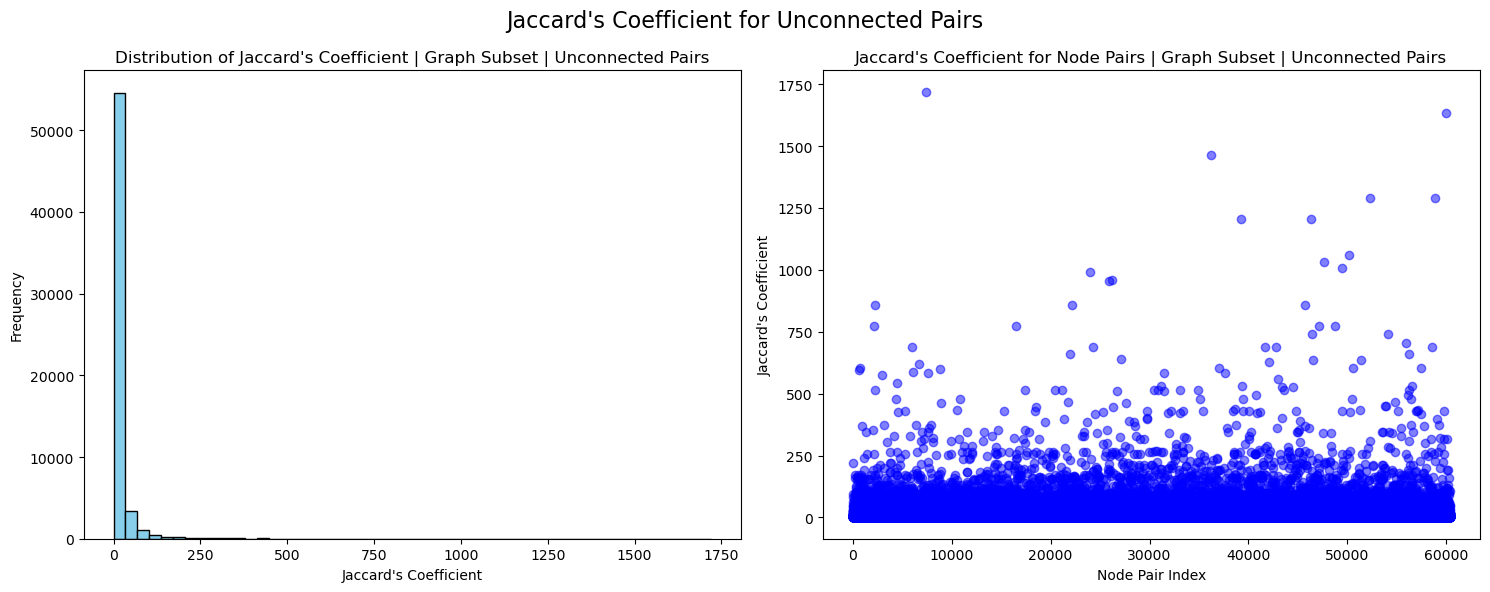

In [35]:
calculate_jaccards_coeff(G)

To determine how closely two personal home pages are linked, Adamic and Adar look into the common features. However, unlike a simple count of these common features, each distinctive or less frequent feature is given more weight in the score which acts as the measure for similarity between entities.

Discussion: We observed the differences between connected and unconnected pairs of nodes. As expected, the values for connected pairs of nodes are larger than those for unconnected pairs of nodes because there is a greater likelihood of shared connections or features when nodes are directly linked.

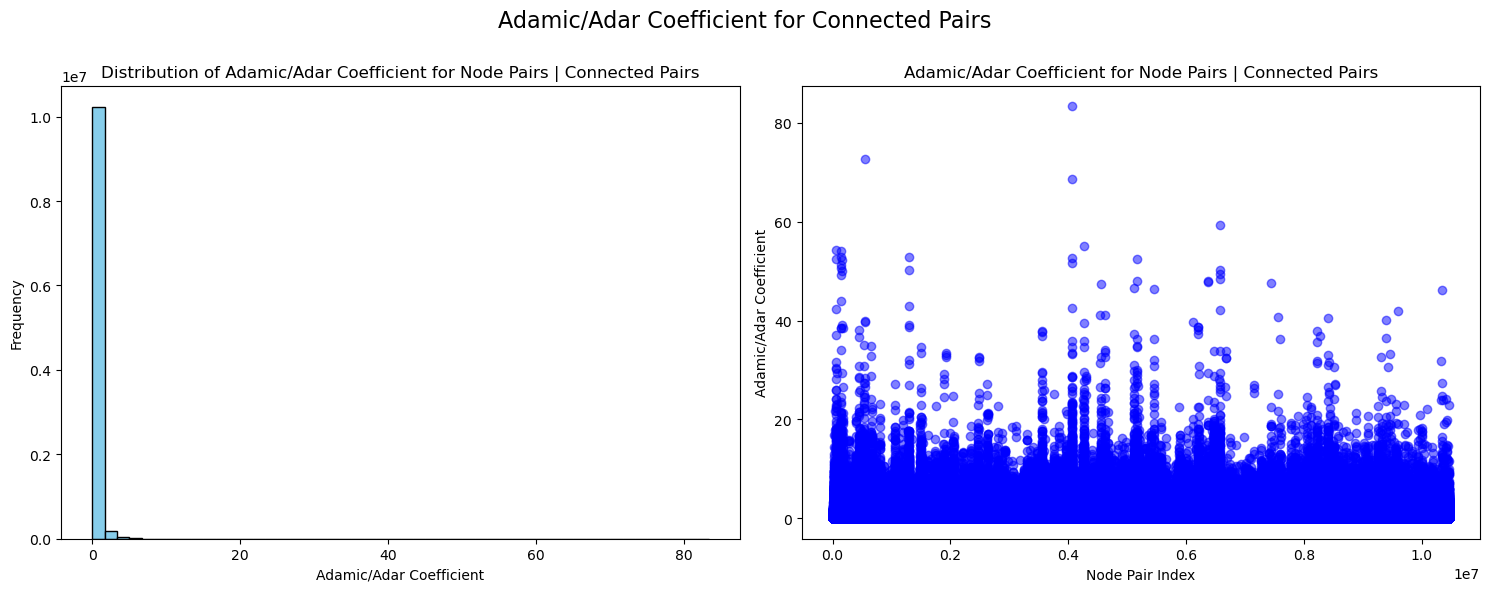

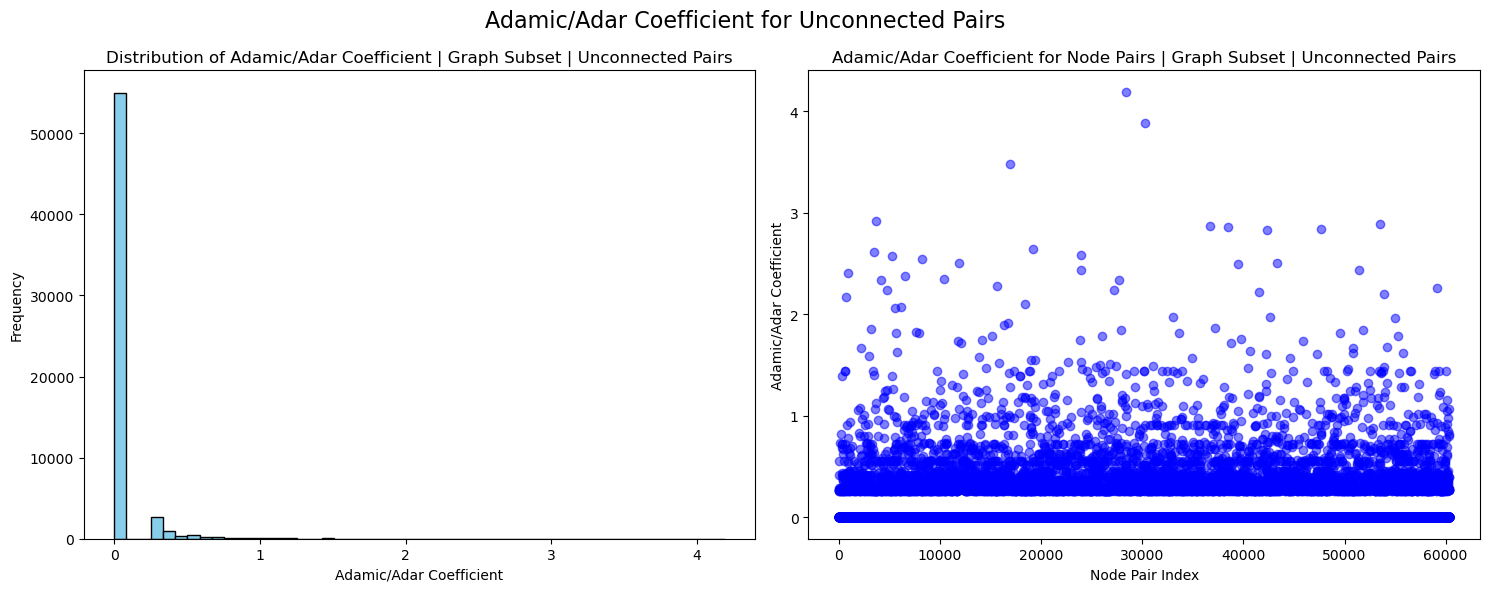

In [25]:
calculate_adamic_adar(G)

In [20]:
#Very clever way to label the nodes apparently, might check the function once again beacuse we should not have 
# some "1" for every hash lol
#It is made to capture a more global concept of neighborhood than the ones above

from collections import defaultdict

def weisfeiler_lehman_step(graph, labels):
    """Perform one WL iteration on the graph and return updated labels."""
    new_labels = {}
    for node in graph.nodes():
        # Create a multi-set label combining the node's current label and its neighbors' labels
        neighborhood = [labels[neighbor] for neighbor in graph.neighbors(node)]
        neighborhood.sort()
        new_labels[node] = hash((labels[node], tuple(neighborhood)))
    return new_labels


# Initial labeling: use node degrees as the initial labels
initial_labels = {node: subgraphs[0].degree(node) for node in subgraphs[0].nodes()}

# Perform a few iterations of the WL algorithm
labels = initial_labels
for i in range(2):  #Tunable number
    labels = weisfeiler_lehman_step(subgraphs[0], labels)
    print(f"Iteration {i + 1}: {labels}")

# Collect the label distribution to create a graph-level feature vector
label_distribution = defaultdict(int)
for label in labels.values():
    label_distribution[label] += 1

print("Graph-level feature vector (label distribution):")
print(dict(label_distribution))


Iteration 1: {'Second_Crusade': -893621644533700915, 'Navassa_Island': 8329283999814967699, 'Evan_Rachel_Wood': 8519113674971457972, 'Tropical_Storm_Henri_(2003)': 626469319377107373, 'Final_Fantasy_Adventure': -3448943065338576981, 'Tornado': 7013476142081247087, 'John_W._Campbell': -9091077964127448255, 'Whooping_Crane': 5312107234228841219, 'Shigin': 5649767532401809945, 'Hafnium': 9120771224082934432, 'Hawaiian_Goose': -3130436553340239897, 'Ankylosaurus': -4906954401919983635, 'Andriyivskyy_Descent': -3895641430901970762, 'Supermarine_Spitfire': -1039804146619362706, 'Carl_Jung': -1198768923331201492, 'Fine_art': 5386708361537680284, 'Arithmetic': 8605665781731028945, 'Taj_Mahal': -12574906297549603, 'Social_capital': -3435835733337879385, 'Nepal': -3773781809479800250, 'Book_of_Common_Prayer': 4096406826054273591, 'African_Buffalo': -3003876494246675907, 'Luminiferous_aether': 3585134803795801146, 'Chicago': -5287685149690895182, 'Giza_pyramid_complex': 7562491782199733120, 'Lyme

In [21]:
#PageRank algorithm, might be useful in our context, it shows how much a page is connected to the others

pr = nx.pagerank(subgraphs[0], alpha=0.9)
df_pagerank = pd.DataFrame(list(pr.items()), columns=['Article', 'PageRank_Score'])
df_pagerank

,Article,PageRank_Score
0,Second_Crusade,0.000135
1,Navassa_Island,0.000263
2,Evan_Rachel_Wood,0.000051
3,Tropical_Storm_Henri_(2003),0.000072
4,Final_Fantasy_Adventure,0.000045
...,...,...
4584,Réunion,0.000224
4585,Flower,0.000505
4586,Banknote,0.000141
4587,Weyto_language,0.000037
